# Data Analysis with Python

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import json
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression


In [2]:
# magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from dataset_creation import create_dataset
df = create_dataset(start_year=2013, end_year=2018)
df.shape

(314, 22)

## Data basic visualization

In [4]:
df.head()

salary  salary_next_year  added_salary      T  \
first_name last_name                                                     
Aaron      Long       11.082143         11.199926      0.125000   True   
           Maund      11.058000         11.390187      0.394014   True   
Adam       Moffat     11.992931         12.081690      0.092817  False   
Adolfo     Machado    12.285364         12.373737      0.092396  False   
Alan       Gordon     12.189266         12.238862      0.050847  False   

                     age_group  team_name  shots_per_game  goals_per_game  \
first_name last_name                                                        
Aaron      Long          27-30   New York        0.647059        0.029412   
           Maund         30-35  Salt Lake        0.363636        0.045455   
Adam       Moffat          >35    Houston        1.076923        0.115385   
Adolfo     Machado         >35    Houston        0.289474        0.000000   
Alan       Gordon          >35   San Jose        1.666667        0.166667   

                      pass_success    rating  ...  assists_per_game  \
first_name last_name                          ...                     
Aaron      Long          76.465662  6.888824  ...          0.000000   
           Maund         73.575949  6.890000  ...          0.045455   
Adam       Moffat        80.550285  6.672308  ...          0.000000   
Adolfo     Machado       78.042328  6.950526  ...          0.052632   
Alan       Gordon        67.918089  6.555000  ...          0.083333   

                      age_group_next_year  team_name_next_year  \
first_name last_name                                             
Aaron      Long                     27-30             New York   
           Maund                    30-35            Salt Lake   
Adam       Moffat                     >35            FC Dallas   
Adolfo     Machado                    >35              Houston   
Alan       Gordon                     >35          L.A. Galaxy   

                     shots_per_game_next_year goals_per_game_next_year  \
first_name last_name                                                     
Aaron      Long                      0.684211                 0.078947   
           Maund                     0.250000                 0.000000   
Adam       Moffat                    0.700000                 0.000000   
Adolfo     Machado                   0.238095                 0.000000   
Alan       Gordon                    1.421053                 0.263158   

                      pass_success_next_year  rating_next_year  \
first_name last_name                                             
Aaron      Long                    69.554849          7.077632   
           Maund                   79.483037          6.974000   
Adam       Moffat                  80.132450          6.543000   
Adolfo     Machado                 80.699482          6.761905   
Alan       Gordon                  73.360656          6.668947   

                      minutes_per_game_next_year  \
first_name last_name                               
Aaron      Long                        83.315789   
           Maund                       87.300000   
Adam       Moffat                      57.600000   
Adolfo     Machado                     80.761905   
Alan       Gordon                      30.421053   

                      man_of_the_match_per_game_next_year  \
first_name last_name                                        
Aaron      Long                                  0.052632   
           Maund                                 0.100000   
Adam       Moffat                                0.000000   
Adolfo     Machado                               0.000000   
Alan       Gordon                                0.000000   

                      assists_per_game_next_year  
first_name last_name                              
Aaron      Long                         0.052632  
           Maund                        0.000000  
Adam       Moffat         

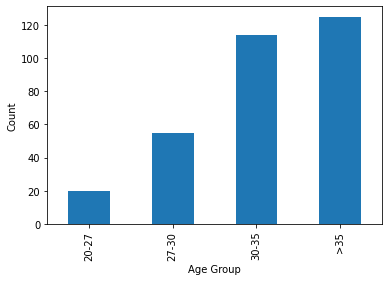

In [5]:
# age group distribution in a bar chart (age group is a categorical variable)
df["age_group"].value_counts().plot(kind="bar")
plt.xlabel("Age Group")
plt.ylabel("Count")

# reverse the x axis
plt.gca().invert_xaxis()



Text(0, 0.5, 'Team Name')

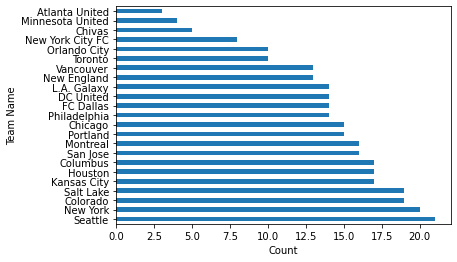

In [6]:
# team distribution in a bar chart (team is a categorical variable)
df["team_name"].value_counts().plot(kind="barh")
plt.xlabel("Count")
plt.ylabel("Team Name")

Correlation between added_salary and rating_next_year: -0.05


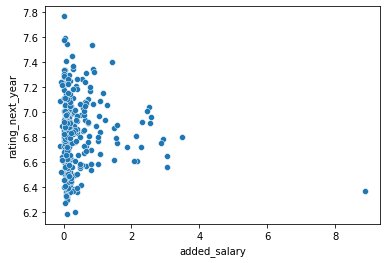

In [7]:
# next year rating based on added_salary 

sns.scatterplot(x="added_salary", y="rating_next_year", data=df)

# corr between added_salary and rating_next_year
corr = df[["added_salary", "rating_next_year"]].corr().loc["added_salary", "rating_next_year"]
print(f"Correlation between added_salary and rating_next_year: {corr:.2f}")

Text(0, 0.5, 'Count')

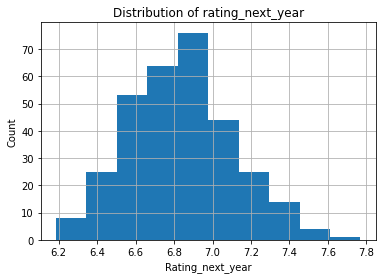

In [8]:
# distribution of rating_next_year continuous variable
df["rating_next_year"].hist()
plt.title("Distribution of rating_next_year")
plt.xlabel("Rating_next_year")
plt.ylabel("Count")

## Overlap between control and treatment groups

In [9]:
T = df["T"]

X = pd.get_dummies(df[[
                       "salary",
                    #    "age_group",
                       "team_name",
                       "rating", 
                       "team_name_next_year", 
                       "shots_per_game",
                       "goals_per_game",
                       "pass_success",
                       "minutes_per_game",
                       "man_of_the_match_per_game",
                       ]])

# 
X["age"] = df["age_group"].map({"20-27": 23, "27-30": 28, "30-35": 32, ">35": 36})

columns = X.columns
index = X.index
# normalize the data
scaler = StandardScaler()
# scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# convert back to dataframe
X = pd.DataFrame(X, columns=columns, index=index)





Y = df["rating_next_year"]

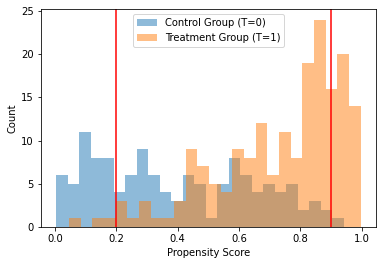

In [10]:
# calc propensity score
from sklearn.linear_model import LogisticRegression, LinearRegression

lr = LogisticRegression(max_iter=1000000)
lr.fit(X, T)
ps = lr.predict_proba(X)[:, 1]

# visualize propensity score
plt.hist(ps[T == 0], bins=25, alpha=0.5, label="Control Group (T=0)")
plt.hist(ps[T == 1], bins=25, alpha=0.5, label="Treatment Group (T=1)")
plt.legend()
# plt.title("Propensity Score before trimming")
plt.ylabel("Count")
plt.xlabel("Propensity Score")



# x line
low_threshold = 0.2
high_threshold = 0.9
plt.axvline(low_threshold, color="red")
plt.axvline(high_threshold, color="red")

In [11]:
ps.min(), ps.max()

(0.004576635956475114, 0.9960474761901558)

In [12]:
# trim outliers
X = X[(ps > low_threshold) & (ps < high_threshold)]
T = T[(ps > low_threshold) & (ps < high_threshold)]
Y = Y[(ps > low_threshold) & (ps < high_threshold)]
df = df[(ps > low_threshold) & (ps < high_threshold)]
ps = ps[(ps > low_threshold) & (ps < high_threshold)]

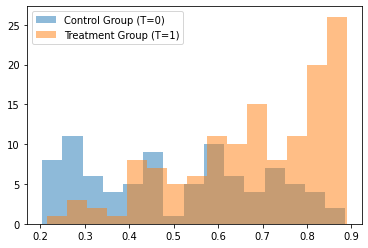

In [13]:
# Propensity after trimming
plt.hist(ps[T == 0], bins=15, alpha=0.5, label="Control Group (T=0)")
plt.hist(ps[T == 1], bins=15, alpha=0.5, label="Treatment Group (T=1)")
plt.legend()


In [14]:
data = X
data["T"] = T
data["Y"] = Y

## Analysis

In [21]:
from calc_ate import calculate_ATE


# estimate variance using bootstrap
def estimate_std(data, method="IPW", n_iter=1000, random_state=0, sample_size=None, **kwargs):
    np.random.seed(random_state)

    if sample_size is None:
        sample_size = len(data)

    ate_list = []
    for _ in range(n_iter):
        idx = np.random.choice(data.index, size=sample_size, replace=True)
        ate_list.append(calculate_ATE(data.loc[idx], method=method, **kwargs))

    ate_list = np.array(ate_list)
    return ate_list.std()

def estimate_ci(data, method="IPW", n_iter=1000, random_state=0, sample_size=None, alpha=0.05, **kwargs):
    np.random.seed(random_state)

    if sample_size is None:
        sample_size = len(data)
    
    ate_list = []
    for _ in range(n_iter):
        idx = np.random.choice(data.index, size=sample_size, replace=True)
        ate_list.append(calculate_ATE(data.loc[idx], method=method, **kwargs))
    
    ate_list = np.array(ate_list)
    # ate_list.sort()
    # lower = ate_list[int(n_iter * alpha / 2)]
    # upper = ate_list[int(n_iter * (1 - alpha / 2))]

    lower, upper = np.quantile(ate_list, [alpha / 2, 1 - alpha / 2])

    return lower, upper

def estimate_model_error(data, method="IPW", n_iter=1000, random_state=0, sample_size=None, **kwargs):
    np.random.seed(random_state)

    if sample_size is None:
        sample_size = len(data)

    error_list = []
    for _ in range(n_iter):
        idx = np.random.choice(data.index, size=sample_size, replace=True)
        test_data = data.loc[data.index.difference(idx)]
        _, error = calculate_ATE(data.loc[idx], method=method, test_data=test_data ,**kwargs)
        error_list.append(error)


    return np.array(error_list).mean()



In [22]:
def calc_method_results(data, method="IPW", n_iter=1000, random_state=0, sample_size=None, alpha=0.05, **kwargs):
    ate = calculate_ATE(data, method=method, **kwargs)
    if isinstance(ate, tuple):
        ate, error = ate
    ate_std = estimate_std(data, 
                           method=method, 
                           n_iter=n_iter, 
                           random_state=random_state, 
                           sample_size=sample_size,
                           **kwargs)
    ate_ci_lower, ate_ci_upper = estimate_ci(data, 
                                             method=method, 
                                             n_iter=n_iter, 
                                             random_state=random_state, 
                                             sample_size=sample_size, 
                                             alpha=alpha,
                                             **kwargs)
    res = [ate, ate_std, ate_ci_lower, ate_ci_upper]

    if kwargs.get("calc_error", False):
        error = estimate_model_error(data, 
                                     method=method, 
                                     n_iter=n_iter, 
                                     random_state=random_state, 
                                     sample_size=sample_size,
                                     **kwargs)
        res.append(error)


    return res

def calc_all_results(data, methods, n_iter=100, sample_size=50, **kwargs):
    results = []
    headers = ["Method", "ATE", "ATE Std", f"ATE (95% CI)"]

    if kwargs.get("calc_error", False):
        headers.append("Model Error")
    
    for method in methods:
        res = calc_method_results(data, method=method, n_iter=n_iter, sample_size=sample_size, **kwargs)
        if kwargs.get("calc_error", False):
            ate, ate_std, ate_ci_lower, ate_ci_upper, error = res
        else:
            ate, ate_std, ate_ci_lower, ate_ci_upper = res
        
        method_results = [method, f"{ate:.4f}", f"{ate_std:.3f}", f"({ate_ci_lower:.3f}, {ate_ci_upper:.3f})"]

        if kwargs.get("calc_error", False):
            method_results.append(f"{error:.3f}")

        results.append(method_results)

    
    return results, headers

### Model Type Analysis

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge


methods = ["S-learner"] * 3
model_type = [Ridge(1e-5), RandomForestRegressor(), GradientBoostingRegressor()]

results_list = []

for method, model in zip(methods, model_type):
    results, headers = calc_all_results(data, [method], n_iter=500, sample_size=50, model_type=model, calc_error=True)
    result = results[0]
    result.insert(1, model)
    results_list.append(results[0])   

headers.insert(1, "Model Type") 

print(tabulate(results_list, headers=headers, tablefmt="raw"))

In [36]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge


methods = ["S-learner"] * 3
model_type = [Ridge(1e-5), RandomForestRegressor(), GradientBoostingRegressor()]

results_list = []

for method, model in zip(methods, model_type):
    results, headers = calc_all_results(data, [method], n_iter=500, sample_size=50, model_type=model, calc_error=True)
    result = results[0]
    result.insert(1, model)
    results_list.append(results[0])   

headers.insert(1, "Model Type") 

print(tabulate(results_list, headers=headers, tablefmt="github"))
print(tabulate(results_list, headers=headers, tablefmt="latex_booktabs"))

| Method    | Model Type                  |    ATE |   ATE Std | ATE (95% CI)    |   Model Error |
|-----------|-----------------------------|--------|-----------|-----------------|---------------|
| S-learner | Ridge(alpha=1e-05)          | 0.0251 |     0.087 | (-0.154, 0.230) |         0.133 |
| S-learner | RandomForestRegressor()     | 0.0036 |     0.008 | (-0.015, 0.018) |         0.06  |
| S-learner | GradientBoostingRegressor() | 0.0067 |     0.013 | (-0.018, 0.035) |         0.07  |
\begin{tabular}{llrrlr}
\toprule
 Method    & Model Type                  &    ATE &   ATE Std & ATE (95\% CI)    &   Model Error \\
\midrule
 S-learner & Ridge(alpha=1e-05)          & 0.0251 &     0.087 & (-0.154, 0.230) &         0.133 \\
 S-learner & RandomForestRegressor()     & 0.0036 &     0.008 & (-0.015, 0.018) &         0.06  \\
 S-learner & GradientBoostingRegressor() & 0.0067 &     0.013 & (-0.018, 0.035) &         0.07  \\
\bottomrule
\end{tabular}


In [37]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge

methods = ["T-learner"] * 3
model_type = [Ridge(1e-4), RandomForestRegressor(), GradientBoostingRegressor()]

results_list = []

for method, model in zip(methods, model_type):
    results, headers = calc_all_results(data, [method], n_iter=500, sample_size=50, model_type=model, calc_error=True)
    result = results[0]
    result.insert(1, model)
    results_list.append(results[0])   

headers.insert(1, "Model Type") 

print(tabulate(results_list, headers=headers, tablefmt="github"))
print(tabulate(results_list, headers=headers, tablefmt="latex_booktabs"))

| Method    | Model Type                  |    ATE |   ATE Std | ATE (95% CI)    |   Model Error |
|-----------|-----------------------------|--------|-----------|-----------------|---------------|
| T-learner | Ridge(alpha=0.0001)         | 0.0302 |     0.204 | (-0.266, 0.328) |         5.123 |
| T-learner | RandomForestRegressor()     | 0.0105 |     0.044 | (-0.084, 0.112) |         0.236 |
| T-learner | GradientBoostingRegressor() | 0.0169 |     0.046 | (-0.085, 0.117) |         0.276 |
\begin{tabular}{llrrlr}
\toprule
 Method    & Model Type                  &    ATE &   ATE Std & ATE (95\% CI)    &   Model Error \\
\midrule
 T-learner & Ridge(alpha=0.0001)         & 0.0302 &     0.204 & (-0.266, 0.328) &         5.123 \\
 T-learner & RandomForestRegressor()     & 0.0105 &     0.044 & (-0.084, 0.112) &         0.236 \\
 T-learner & GradientBoostingRegressor() & 0.0169 &     0.046 & (-0.085, 0.117) &         0.276 \\
\bottomrule
\end{tabular}


### Answering the Question

In [39]:
methods = ["IPW", "S-learner", "T-learner", "Matching"]
model_type = [None, RandomForestRegressor(), RandomForestRegressor(), None]

results, headers = calc_all_results(data, methods, n_iter=50, sample_size=50)


results_list = []

for method, model in zip(methods, model_type):
    if model is None:
        results, headers = calc_all_results(data, [method], n_iter=500, sample_size=50)
    else:
        results, headers = calc_all_results(data, [method], n_iter=500, sample_size=50, model_type=model)
    result = results[0]
    result.insert(1, model if model is not None else "---")
    results_list.append(results[0])   

headers.insert(1, "Model Type") 



print(tabulate(results, headers=headers, tablefmt="github"))
print(tabulate(results_list, headers=headers, tablefmt="latex_booktabs"))

| Method   | Model Type   |     ATE |   ATE Std | ATE (95% CI)    |
|----------|--------------|---------|-----------|-----------------|
| Matching | ---          | -0.0243 |     0.083 | (-0.163, 0.158) |
\begin{tabular}{llrrl}
\toprule
 Method    & Model Type              &     ATE &   ATE Std & ATE (95\% CI)    \\
\midrule
 IPW       & ---                     & -0.0815 &     0.923 & (-0.531, 3.100) \\
 S-learner & RandomForestRegressor() &  0.0036 &     0.011 & (-0.019, 0.023) \\
 T-learner & RandomForestRegressor() &  0.016  &     0.062 & (-0.098, 0.132) \\
 Matching  & ---                     & -0.0243 &     0.083 & (-0.163, 0.158) \\
\bottomrule
\end{tabular}


In [40]:
def calc_results_top_level(data, n_iter=500):
    methods = ["IPW", "S-learner", "T-learner", "Matching"]
    model_type = [None, RandomForestRegressor(), RandomForestRegressor(), None]

    results, headers = calc_all_results(data, methods, n_iter=50, sample_size=50)


    results_list = []

    for method, model in zip(methods, model_type):
        if model is None:
            results, headers = calc_all_results(data, [method], n_iter=500, sample_size=50)
        else:
            results, headers = calc_all_results(data, [method], n_iter=500, sample_size=50, model_type=model)
        result = results[0]
        result.insert(1, model if model is not None else "---")
        results_list.append(results[0])   

    headers.insert(1, "Model Type") 

    print(tabulate(results, headers=headers, tablefmt="github"))
    print(tabulate(results_list, headers=headers, tablefmt="latex_booktabs"))

## SubGroup Analysis

### Per Age Group

In [42]:
# age_groups = dfdata.columns[data.columns.str.contains("age_group")].str.replace("age_group_", "").values
age_groups = df["age_group"].unique()
# sort age groups
age_groups = np.sort(age_groups)
for age_group in age_groups:
    print("Age group:", age_group)
    print("===")
    mask = df["age_group"] == age_group
    data_age_group = data[mask]

    # results, headers = calc_all_results(data_age_group, methods, n_iter=500, sample_size=50)
    # print(tabulate(results, headers=headers, tablefmt="github"))
    calc_results_top_level(data_age_group, n_iter=500)

Age group: 20-27
===
| Method   | Model Type   |    ATE |   ATE Std | ATE (95% CI)    |
|----------|--------------|--------|-----------|-----------------|
| Matching | ---          | 0.0035 |     0.048 | (-0.085, 0.103) |
\begin{tabular}{llrrl}
\toprule
 Method    & Model Type              &    ATE &   ATE Std & ATE (95\% CI)    \\
\midrule
 IPW       & ---                     & 2.4807 &     0.828 & (0.991, 4.073)  \\
 S-learner & RandomForestRegressor() & 0.0135 &     0.011 & (-0.010, 0.030) \\
 T-learner & RandomForestRegressor() & 0.0307 &     0.062 & (-0.043, 0.209) \\
 Matching  & ---                     & 0.0035 &     0.048 & (-0.085, 0.103) \\
\bottomrule
\end{tabular}
Age group: 27-30
===


In [ ]:
# age_groups = dfdata.columns[data.columns.str.contains("age_group")].str.replace("age_group_", "").values
age_groups = df["age_group"].unique()
# sort age groups
age_groups = np.sort(age_groups)
for age_group in age_groups:
    print("Age group:", age_group)
    print("===")
    mask = df["age_group"] == age_group
    data_age_group = data[mask]

    # results, headers = calc_all_results(data_age_group, methods, n_iter=500, sample_size=50)
    # print(tabulate(results, headers=headers, tablefmt="github"))
    calc_results_top_level(data_age_group, n_iter=500)

### Per Team

In [ ]:
teams = df["team_name_next_year"].unique()
for team in teams:
    print("Team:", team)
    print("===")
    mask = df["team_name_next_year"] == team
    data_team = data[mask]

    # results, headers = calc_all_results(data_age_group, methods, n_iter=500, sample_size=50)
    # print(tabulate(results, headers=headers, tablefmt="github"))
    calc_results_top_level(data_team, n_iter=500)


In [48]:
# teams = df["team_name_next_year"].unique()
# for team in teams:
#     print("Team:", team)
#     print("===")
#     mask = df["team_name_next_year"] == team
#     data_team = data[mask]

#     results, headers = calc_all_results(data_team, methods, n_iter=30, sample_size=50)
#     print(tabulate(results, headers=headers, tablefmt="github"))

    

Team: Houston
===
| Method    |    ATE |   ATE Std | ATE (95% CI)   |
|-----------|--------|-----------|----------------|
| T-learner | 0.4175 |     0.075 | (0.258, 0.516) |
| T-learner | 0.4175 |     0.075 | (0.258, 0.516) |
| T-learner | 0.4175 |     0.075 | (0.258, 0.516) |
Team: L.A. Galaxy
===
| Method    |    ATE |   ATE Std | ATE (95% CI)    |
|-----------|--------|-----------|-----------------|
| T-learner | 0.0549 |     0.044 | (-0.023, 0.136) |
| T-learner | 0.0549 |     0.044 | (-0.023, 0.136) |
| T-learner | 0.0549 |     0.044 | (-0.023, 0.136) |
Team: New York
===
| Method    |     ATE |   ATE Std | ATE (95% CI)    |
|-----------|---------|-----------|-----------------|
| T-learner | -0.1107 |     0.058 | (-0.205, 0.009) |
| T-learner | -0.1107 |     0.058 | (-0.205, 0.009) |
| T-learner | -0.1107 |     0.058 | (-0.205, 0.009) |
Team: New York City FC
===
| Method    |    ATE |   ATE Std | ATE (95% CI)    |
|-----------|--------|-----------|-----------------|
| T-learner |

KeyboardInterrupt: 